# Расчетная часть

In [1]:
# Загрузка библиотек необходимых для отрисовки графиков
import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint
%matplotlib inline  

In [2]:
# функция расчета плотности воды в зависимости от давления и температуры
def rho_w_kgm3(P_Mpa,T_K):
    rho_w_sc_kgm3 = rho_wh
    return rho_w_sc_kgm3 /(1+(T_K-273)/10000*(0.269*(T_K-273)**(0.637)-0.8))
    
# Расчет вязкости воды в зависимости от температуры и давления
def visc_w_cP(P_Mpa,T_K):
    A = 109.574
    B = 1.1217
    muw = A * (1.8 * T_K - 460) ** (-B) * (0.9994 + 0.0058 * P_Mpa + 0.6534 * (10) ** (0 - 4) * P_Mpa * P_Mpa)
    return muw

# Расчет числа Рейнольдса 
def Re(q_m3day, d_m, mu_mPas = 0.2, rho_kgm3 = 1000):
    # q_m3day - дебит жидкости, м3/сут
    # rho_kgm3 - плотность воды или жидкости, по умолчанию 1000 кг/м3, чистая вода
    # mu_mPas  - вязкость жидкости по умолчанию 0.2 мПас
    # d_m      - диаметр трубы, м
    v_ms = q_m3day/ 86400 / 3.1415 * 4 / d_m ** 2
    return rho_kgm3 * v_ms * d_m / mu_mPas * 1000

def friction(q_m3day, eps, d_m = 0.089, mu_mPas = 0.2,rho_kgm3 = 1000):
    Re_val = Re(q_m3day, d_m, mu_mPas, rho_kgm3)
    if Re_val < 3000:
        return 64/Re_val
    else:
        return 1/(1.14-2 * np.log10(eps/d_m + 21.25 / (Re_val ** 0.9)))**2

# функция расчета градиента давления в нагнетательной скважин
def pressure_gradient_MPam(q_m3day, eps, P_Mpa, T_C, d_m = 0.089, cos_alpha = 1):
    # q_m3day - дебит жидкости, м3/сут
    # P_Mpa - давление, МПа
    # T_C - температура, С
    # d_m - диаметр 
    # Ws - соленость 
    # cos_alpha - косинус угол отклонения от вертикали 
    # roughness_m - шероховатость
    rho_kgm3 = rho_w_kgm3(P_Mpa, T_C + 273)
    mu_cP = visc_w_cP(P_Mpa, T_C + 273)
    f = friction(q_m3day, eps, d_m, mu_cP, rho_kgm3)
    g = 9.81
    q_m3sec = q_m3day /86400
    return (rho_kgm3 * g * cos_alpha - 0.815 * f * rho_kgm3 /( d_m ** 5) * (q_m3sec )**2) / 1000000

# Исходные данные

In [3]:
import json
input_data = '{"gamma_w":1.17, "h":2420, "d_in":95, "q_liq":834, "eps":9.1E-5, "p_wh":17.2, "MD":[0, 1210, 2420], "TVD":[0, 1162.5, 2135], "T0": 21.8}'
exc = json.loads(input_data)

In [4]:
# Исходные данные для проведения расчета
Q = exc["q_liq"]               # дебит скважин м3/сут
Pwh = exc["p_wh"]/10           # давление на устье, МПа
Twh = exc["T0"]                # температура на устье скважины, град С
TempGrad = 0.02342             # температурный градиент град С на м
H = exc["h"]                   # измеренная глубина забоя скважины
dtub_m = exc["d_in"]/1000      # диаметр нагнетательной НКТ, м
e = exc["eps"]                 # Шероховатость, м
rho_wh = exc["gamma_w"]*1000   # Удельная плотность, кг/м3

# траектория скважины, данные инклинометрии
Hmes_m = np.array(exc["MD"])
Hvert_m = np.array(exc["TVD"])

# Построение графиков для конструкции скважины
Выполним построение конструкции скважины для наглядности и выполним интерполяции косинусов. 
Поскольку инклинометрия есть только в трех точках, используем линейную интерполяцию.

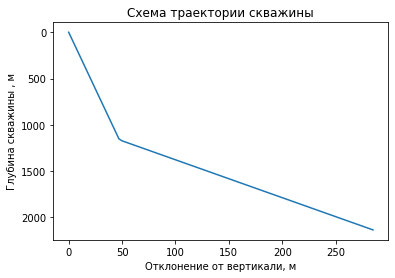

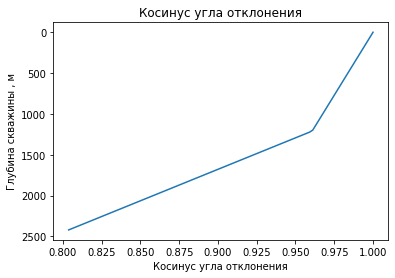

In [5]:
# Подготовка данных по конструкции скважины
# удлинение от измеренной длины - для отрисовки графика
Udl_m = interp1d(Hmes_m,Hmes_m-Hvert_m, kind='linear')
# вертикальная глубина от измеренной
Hv_m = interp1d(Hmes_m,Hvert_m, kind='linear', bounds_error=False)

# построим массив косинусов углов отклонения от вертикали
Cos_ang = np.diff(Hvert_m)/np.diff(Hmes_m)
Cos_ang_red = np.insert(Cos_ang, 0, 1)
Cos_interp = interp1d(Hmes_m , Cos_ang_red, fill_value='extrapolate')


# готовим данные для отрисовки графика
h_ = np.linspace(0, H, num=100, endpoint=True)

plt.plot(Udl_m(h_), Hv_m(h_), '-')
plt.xlabel("Отклонение от вертикали, м")
plt.ylabel("Глубина скважины , м")
plt.title("Схема траектории скважины")
ax = plt.gca()
ax.invert_yaxis()
plt.show()

plt.plot(Cos_interp(h_), (h_), '-')
plt.xlabel("Косинус угла отклонения")
plt.ylabel("Глубина скважины , м")
plt.title("Косинус угла отклонения")
ax = plt.gca()
ax.invert_yaxis()
plt.show()

# Решение системы дифференциальных уравнений

In [6]:
# определим функцию для интергрирования
def dPTdL(PT, h):
    dPdL = round(pressure_gradient_MPam(q_m3day = Q, eps = e, P_Mpa = PT[0], T_C = PT[1], d_m = dtub_m, cos_alpha = Cos_interp(h)),5)
    dTdL = TempGrad * Cos_interp(h)
    return [dPdL, dTdL]

# задаем граничные условия
PTwh = [Pwh,Twh]
# определяем диапазон и интервалы интегрирования
hs = np.linspace(0, H, 100)
# решаем систему уравнений численно
PTs = odeint(dPTdL, PTwh, hs)
# сохраняем результаты расчета
P = PTs[:,0]
T = PTs[:,1]

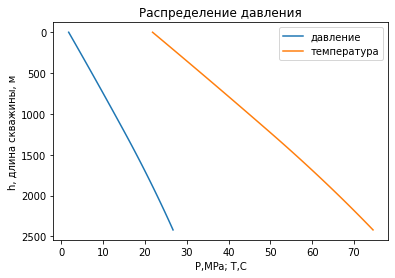

In [7]:
plt.plot(P,hs, label ="давление")
plt.plot(T,hs, label = "температура")
plt.xlabel("P,MPa; Т,C")
plt.ylabel("h, длина скважины, м")
ax = plt.gca()
ax.invert_yaxis()
plt.legend()
plt.title("Распределение давления");

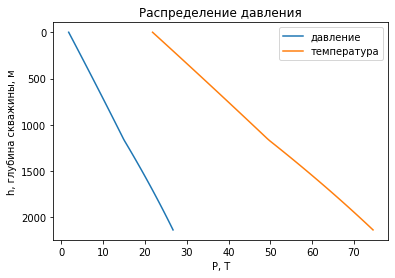

In [8]:
plt.plot(P,Hv_m(hs), label ="давление")
plt.plot(T,Hv_m(hs), label = "температура")
plt.xlabel("P, Т")
plt.ylabel("h, глубина скважины, м")
ax = plt.gca()
ax.invert_yaxis()
plt.legend()
plt.title("Распределение давления");

# Зависимость забойного давления от дебита

In [9]:
Q_var = np.linspace(10, 500, 10)
def dPTdL_1(PT, h, q):
    dPdL = round(pressure_gradient_MPam(q_m3day = q, eps = e, P_Mpa = PT[0], T_C = PT[1], d_m = dtub_m, cos_alpha = Cos_interp(h)),5)
    dTdL = TempGrad
    return [dPdL, dTdL]

Ps = ([])
for q_var in Q_var:
    PTs = odeint(dPTdL_1, PTwh, hs, (q_var,))
    P = np.amax(PTs[:,0], 0)
    Ps = np.append(Ps, P)



Строим зависимость

Text(0.5, 1.0, 'Зависимость забойного давления от дебита')

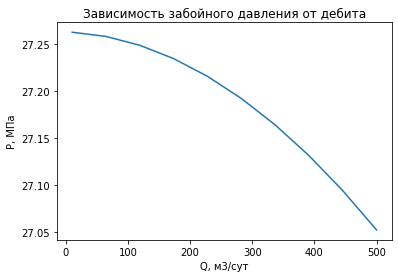

In [10]:
plt.plot(Q_var, Ps)
plt.xlabel("Q, м3/сут")
plt.ylabel("P, МПа")
plt.title("Зависимость забойного давления от дебита")

# Зависимость забойного давления от температуры на устье

In [11]:
def dPTdL_2(PT, h):
    dPdL = round(pressure_gradient_MPam(q_m3day = Q, eps = e, P_Mpa = PT[0], T_C = PT[1], d_m = dtub_m, cos_alpha = Cos_interp(h)),5)
    dTdL = TempGrad
    return [dPdL, dTdL]

Ps_2 = ([])
T_var = np.linspace(10, 50, 10)
for T in T_var:
    PTwh_var = [Pwh,T]
    PTs_2 = odeint(dPTdL_2, PTwh_var, hs)
    P_2 = np.amax(PTs_2[:,0], 0)
    Ps_2 = np.append(Ps_2, P_2)

Text(0.5, 1.0, 'Зависимость забойного давления от температуры на устье')

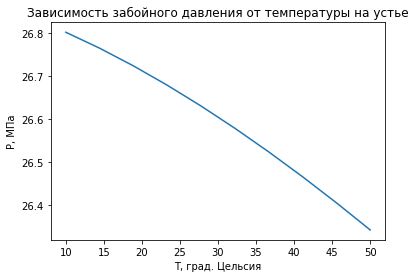

In [12]:
plt.plot(T_var, Ps_2)
plt.xlabel("T, град. Цельсия")
plt.ylabel("P, МПа")
plt.title("Зависимость забойного давления от температуры на устье")

# Ответ на задание в формате .json

In [13]:
answer = json.dumps({"ex1":{"h": hs.tolist(), "p": P.tolist()}, "ex2":{"q_liq": Q_var.tolist(), "p_wf": Ps.tolist()}, "ex3":{"t": T_var.tolist(), "p_wf": Ps_2.tolist()}})
with open('Answer_strokin.json', 'w', encoding='utf-8') as f:
    f.write(answer)